In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering,DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
import warnings
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
np.random.seed(42)
warnings.filterwarnings('ignore')


# Clustering Algorithms with Hyperparameter Research and 2D Visualization

In [2]:
data1=pd.read_csv("C:/Users/DELL/Downloads/data.csv")

In [4]:
class OutlierReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, factor=3.0):
        self.factor = factor

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for i in range(X.shape[1]):
            col = X[:, i]
            q1, q3 = np.percentile(col, [25, 75])
            IQR = q3 - q1
            l_bound = q1 - self.factor * IQR
            u_bound = q3 + self.factor * IQR

            if u_bound == 0:
                continue

            col[col < l_bound] = l_bound
            col[col > u_bound] = u_bound

        return X

In [21]:
def preprocess_data(data):
    data_encoded = data.copy()
    month_to_num = {
        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'June': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    }
    visitor_to_num = {
        'Returning_Visitor': 2, 'New_Visitor': 1, 'Other': 0
    }

    data_encoded['Month'] = data_encoded['Month'].map(month_to_num)
    data_encoded['VisitorType'] = data_encoded['VisitorType'].map(visitor_to_num)

    label_encoder = LabelEncoder()
    data_encoded['Weekend'] = label_encoder.fit_transform(data_encoded['Weekend'])
    data_encoded['Revenue'] = label_encoder.fit_transform(data_encoded['Revenue'])

    preprocessor = ColumnTransformer(
        transformers=[
            ('scaler', StandardScaler(), data_encoded.columns),
        ],
        remainder='passthrough'
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('outlier_replacer', OutlierReplacer(factor=3.0)),
    ])

    data_encoded = pipeline.fit_transform(data_encoded)

    return pd.DataFrame(data_encoded)

## Data Preprocessing

In [26]:
train=preprocess_data(data1)

def apply_pca(data, n_components=2):
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data)
    return pd.DataFrame(data_pca, columns=[f'PC{i+1}' for i in range(n_components)])



In [13]:
data_pca = apply_pca(train)

## Hyperparameter Research


In [7]:

def evaluate_clustering(data, labels):
    score = silhouette_score(data, labels)
    return score


def kmeans_hyperparameter_research(data, param_grid):
    best_score = -1
    best_params = None
    for params in ParameterGrid(param_grid):
        kmeans = KMeans(**params, random_state=42)
        labels = kmeans.fit_predict(data)
        score = evaluate_clustering(data, labels)
        if score > best_score:
            best_score = score
            best_params = params
    return best_params, best_score


def hierarchical_hyperparameter_research(data, param_grid):
    best_score = -1
    best_params = None
    for params in ParameterGrid(param_grid):
        agg_clustering = AgglomerativeClustering(**params)
        labels = agg_clustering.fit_predict(data)
        score = evaluate_clustering(data, labels)
        if score > best_score:
            best_score = score
            best_params = params
    return best_params, best_score


def gmm_hyperparameter_research(data, param_grid):
    best_score = -1
    best_params = None
    for params in ParameterGrid(param_grid):
        gmm = GaussianMixture(**params, random_state=42)
        labels = gmm.fit_predict(data)
        score = evaluate_clustering(data, labels)
        if score > best_score:
            best_score = score
            best_params = params
    return best_params, best_score

def dbscan_hyperparameter_research(data, param_grid):
    best_score = -1
    best_params = None
    for params in ParameterGrid(param_grid):
        dbscan = DBSCAN(**params)
        labels = dbscan.fit_predict(data)
        # Silhouette score requires at least 2 clusters
        if len(set(labels)) > 1:
            score = evaluate_clustering(data, labels)
            if score > best_score:
                best_score = score
                best_params = params
    return best_params, best_score

In [8]:

kmeans_param_grid = {
    'n_clusters': [2, 3, 4, 5],
    'init': ['k-means++', 'random'],
    'n_init': [10, 20],
    'max_iter': [300, 600]
}

hierarchical_param_grid = {
    'n_clusters': [2, 3, 4, 5],
    'linkage': ['ward', 'complete', 'average', 'single']
}

gmm_param_grid = {
    'n_components': [2, 3, 4, 5],
    'covariance_type': ['full', 'tied', 'diag', 'spherical']
}

dbscan_param_grid = {
    'eps': [0.3, 0.5, 0.7],
    'min_samples': [5, 10, 15]
}

In [9]:
print("\nK-Means Hyperparameter Research:")
best_kmeans_params, best_kmeans_score = kmeans_hyperparameter_research(train, kmeans_param_grid)
print(f"Best K-Means Params: {best_kmeans_params}, Best Score: {best_kmeans_score:.2f}")


K-Means Hyperparameter Research:
Best K-Means Params: {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 2, 'n_init': 10}, Best Score: 0.21


In [10]:
print("\nHierarchical Clustering Hyperparameter Research:")
best_hierarchical_params, best_hierarchical_score = hierarchical_hyperparameter_research(train, hierarchical_param_grid)
print(f"Best Hierarchical Params: {best_hierarchical_params}, Best Score: {best_hierarchical_score:.2f}")


Hierarchical Clustering Hyperparameter Research:
Best Hierarchical Params: {'linkage': 'single', 'n_clusters': 2}, Best Score: 0.46


In [12]:

print("\nGMM Hyperparameter Research:")
best_gmm_params, best_gmm_score = gmm_hyperparameter_research(train, gmm_param_grid)
print(f"Best GMM Params: {best_gmm_params}, Best Score: {best_gmm_score:.2f}")



GMM Hyperparameter Research:
Best GMM Params: {'covariance_type': 'spherical', 'n_components': 2}, Best Score: 0.23


In [13]:
print("\nDBSCAN Hyperparameter Research:")
best_dbscan_params, best_dbscan_score = dbscan_hyperparameter_research(train, dbscan_param_grid)
print(f"Best DBSCAN Params: {best_dbscan_params}, Best Score: {best_dbscan_score:.2f}")


DBSCAN Hyperparameter Research:
Best DBSCAN Params: {'eps': 0.7, 'min_samples': 15}, Best Score: -0.22


## Clustering with Best Hyperparameters

In [14]:

def kmeans_clustering(data, params):
    kmeans = KMeans(**params, random_state=42)
    labels = kmeans.fit_predict(data)
    return labels

def hierarchical_clustering(data, params):
    agg_clustering = AgglomerativeClustering(**params)
    labels = agg_clustering.fit_predict(data)
    return labels

def gmm_clustering(data, params):
    gmm = GaussianMixture(**params, random_state=42)
    labels = gmm.fit_predict(data)
    return labels

def dbscan_clustering(data, params):
    dbscan = DBSCAN(**params)
    labels = dbscan.fit_predict(data)
    return labels

kmeans_labels = kmeans_clustering(train, best_kmeans_params)
hierarchical_labels = hierarchical_clustering(train, best_hierarchical_params)
gmm_labels = gmm_clustering(train, best_gmm_params)
dbscan_labels = dbscan_clustering(train, best_dbscan_params)


AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [27]:
train['kmeans_labels'] = kmeans_labels
train['hierarchical_labels'] = hierarchical_labels
train['gmm_labels'] = gmm_labels
train['dbscan_labels'] = dbscan_labels

## 2D Visualization

In [36]:

def plot_clusters_2d(data, labels, title):
    fig = plt.figure()
    ax = fig.add_subplot()
    scatter = ax.scatter(data['PC1'], data['PC2'], c=labels, cmap='viridis')
    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(title)
    plt.show()

# print("\nPlotting Clusters:")
# plot_clusters_2d(data_pca, kmeans_labels, "K-Means Clustering with Best Hyperparameters")
# plot_clusters_2d(data_pca, hierarchical_labels, "Hierarchical Clustering with Best Hyperparameters")
# plot_clusters_2d(data_pca, gmm_labels, "GMM Clustering with Best Hyperparameters")
# plot_clusters_2d(data_pca, dbscan_labels, "DBSCAN Clustering with Best Hyperparameters")

## Metrics


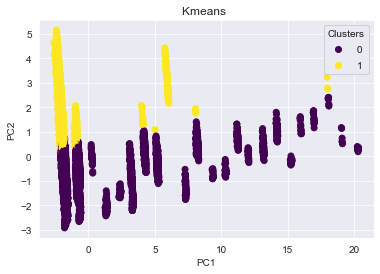

In [37]:
plot_clusters_2d(apply_pca(train),kmeans_labels,"Kmeans ")

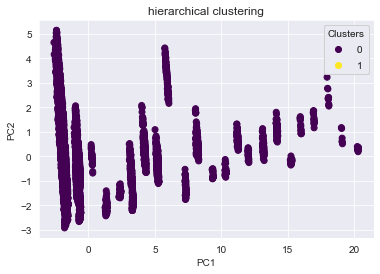

In [38]:
plot_clusters_2d(apply_pca(train),hierarchical_labels,"hierarchical clustering")

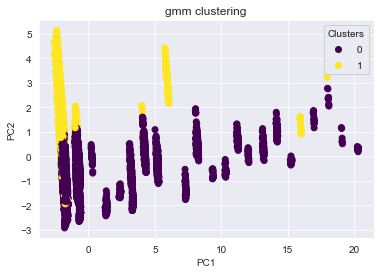

In [39]:
plot_clusters_2d(apply_pca(train),gmm_labels,"gmm clustering")

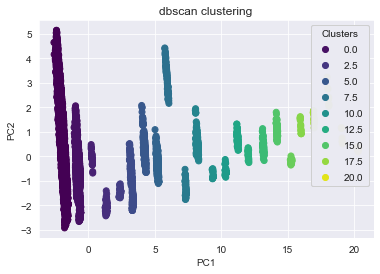

In [40]:
plot_clusters_2d(apply_pca(train),dbscan_labels,"dbscan clustering")

In [41]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

sil_score1 = silhouette_score(train, kmeans_labels)
db_score1 = davies_bouldin_score(train, kmeans_labels)

sil_score2 = silhouette_score(train, hierarchical_labels)
db_score2 = davies_bouldin_score(train, hierarchical_labels)

sil_score3 = silhouette_score(train, gmm_labels)
db_score3 = davies_bouldin_score(train, gmm_labels)

sil_score4 = silhouette_score(train, dbscan_labels)
db_score4 = davies_bouldin_score(train, dbscan_labels)

print(f'KMeans Silhouette Score: {sil_score1}', f' KMeans Davies-Bouldin Index: {db_score1}')
print(f'Hierarchical Silhouette Score: {sil_score2}', f' Hierarchical Davies-Bouldin Index: {db_score2}')
print(f'GMM Silhouette Score: {sil_score3}', f' GMM Davies-Bouldin Index: {db_score3}')
print(f'Dbscan Silhouette Score: {sil_score4}', f' Dbscan Davies-Bouldin Index: {db_score4}')

KMeans Silhouette Score: 0.11445364533029154  KMeans Davies-Bouldin Index: 1.9485489374951646
Hierarchical Silhouette Score: 0.2902798302130055  Hierarchical Davies-Bouldin Index: 0.5783997339651311
GMM Silhouette Score: 0.13509801587097509  GMM Davies-Bouldin Index: 2.016315377241467
Dbscan Silhouette Score: 0.13371331967188435  Dbscan Davies-Bouldin Index: 0.6965053003669557


In [42]:
labels, counts = np.unique(hierarchical_labels, return_counts=True)
for label, count in zip(labels, counts):
    print(f'Hierarchical Cluster {label}: {count} instances')

labels, counts = np.unique(gmm_labels, return_counts=True)
for label, count in zip(labels, counts):
    print(f'GMM Cluster {label}: {count} instances')

# GMM2 the most balanced

Hierarchical Cluster 0: 9863 instances
Hierarchical Cluster 1: 1 instances
GMM Cluster 0: 7517 instances
GMM Cluster 1: 2347 instances


In [44]:
labels, counts = np.unique(dbscan_labels, return_counts=True)
for label, count in zip(labels, counts):
    print(f'DBScan Cluster {label}: {count} instances')

DBScan Cluster -1: 5153 instances
DBScan Cluster 0: 2840 instances
DBScan Cluster 1: 31 instances
DBScan Cluster 2: 101 instances
DBScan Cluster 3: 56 instances
DBScan Cluster 4: 293 instances
DBScan Cluster 5: 321 instances
DBScan Cluster 6: 338 instances
DBScan Cluster 7: 93 instances
DBScan Cluster 8: 53 instances
DBScan Cluster 9: 190 instances
DBScan Cluster 10: 22 instances
DBScan Cluster 11: 51 instances
DBScan Cluster 12: 73 instances
DBScan Cluster 13: 21 instances
DBScan Cluster 14: 73 instances
DBScan Cluster 15: 60 instances
DBScan Cluster 16: 29 instances
DBScan Cluster 17: 18 instances
DBScan Cluster 18: 15 instances
DBScan Cluster 19: 12 instances
DBScan Cluster 20: 6 instances
DBScan Cluster 21: 15 instances


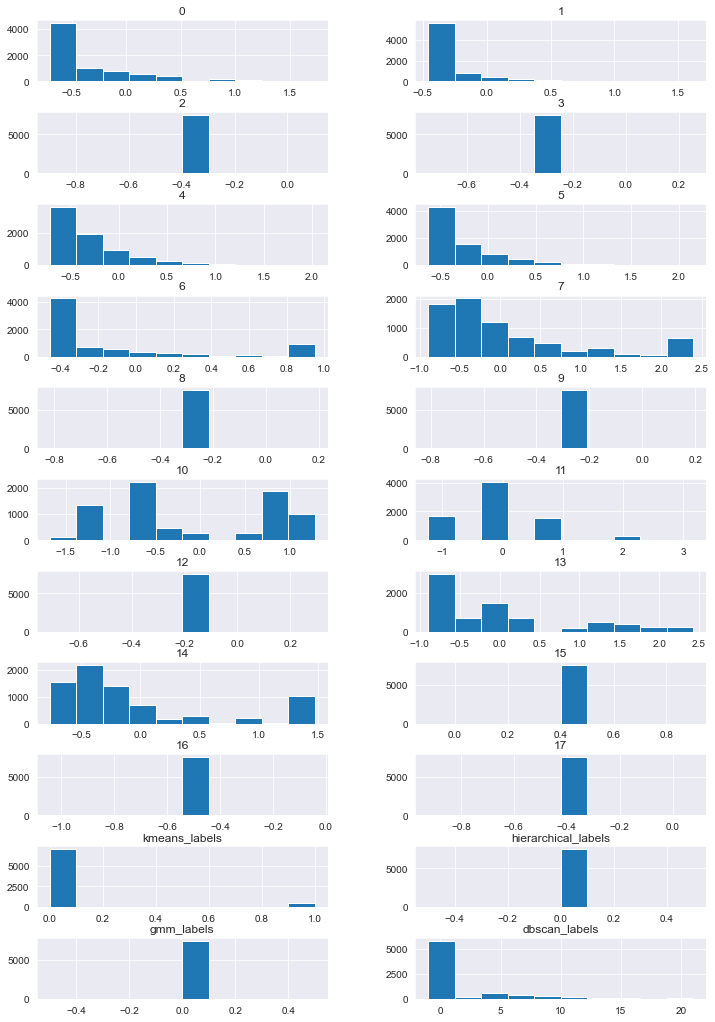

In [52]:
train[train['gmm_labels']==0].hist(figsize=(12,18), layout=(11, 2),bins=10)
plt.subplots_adjust(hspace=0.5)

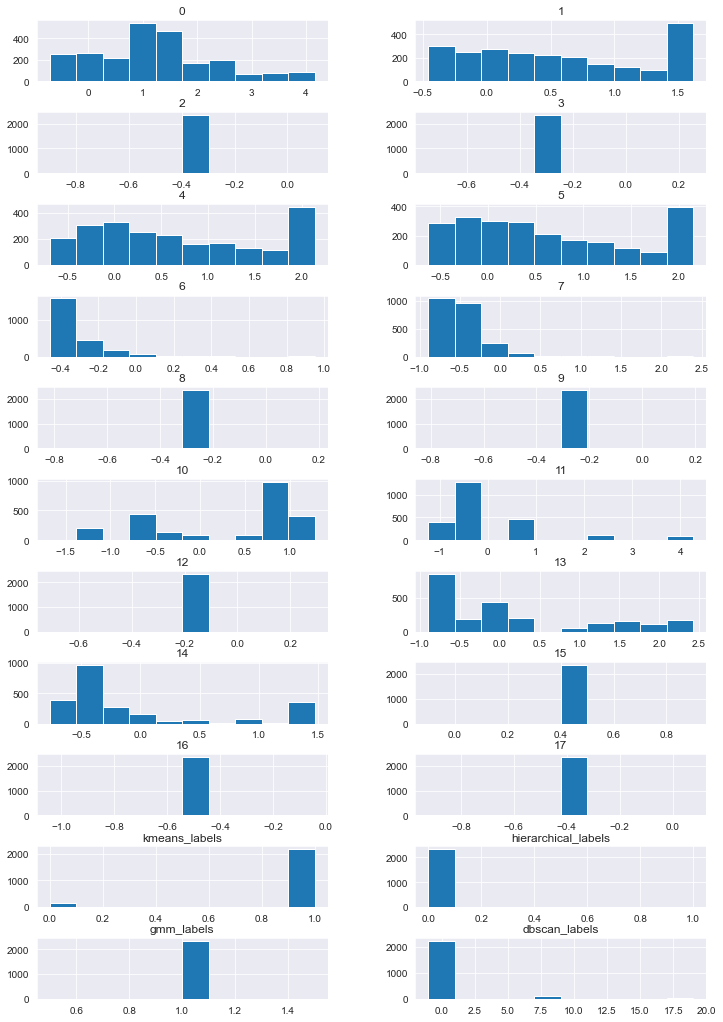

In [53]:
train[train['gmm_labels']==1].hist(figsize=(12,18), layout=(11, 2),bins=10)
plt.subplots_adjust(hspace=0.5)

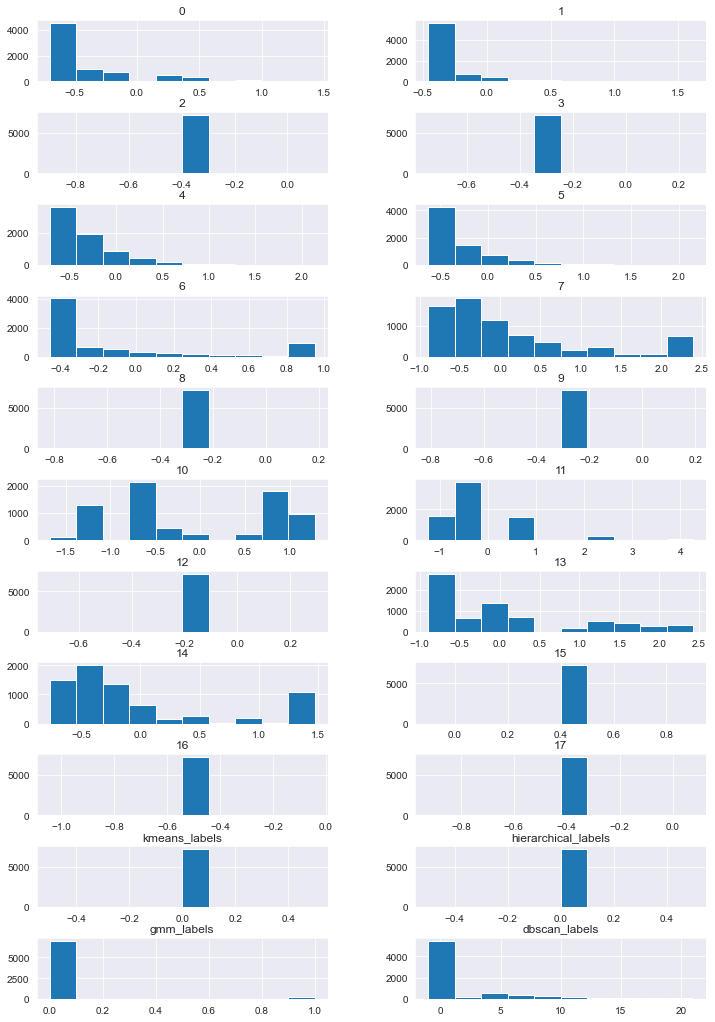

In [54]:
train[train['kmeans_labels']==0].hist(figsize=(12,18), layout=(11, 2),bins=10)
plt.subplots_adjust(hspace=0.5)

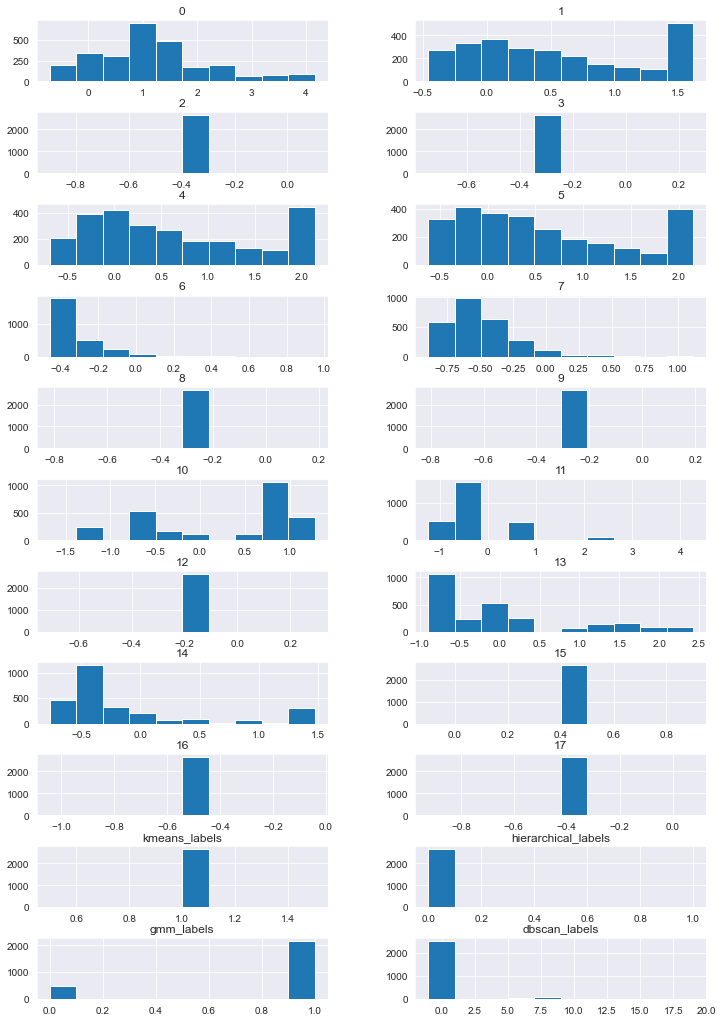

In [55]:
train[train['kmeans_labels']==1].hist(figsize=(12,18), layout=(11, 2),bins=10)
plt.subplots_adjust(hspace=0.5)